# Energy Consumption Forecasting

## Table of Contents
1. [Problem Statement](#problem)
2. [Data Loading & Cleaning](#data-cleaning)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Baseline Models](#baselines)
5. [Advanced Models](#advanced)
6. [Results](#results)

<a id="problem"></a>
## 1. Problem Statement

**Objective:** Forecast hourly electricity consumption (kWh) for multiple buildings, using:
- Historical usage (single-building time series).
- Weather covariates (temperature, wind, etc.).

**Key Steps:**
1. Clean & merge raw data.
2. Explore temporal & weather-load relationships.
3. Implement classical baseline models.
4. Develop advanced sequence (GRU) and tree-based (XGBoost) models.
5. Compare performance using **Mean Absolute Percentage Error (MAPE)**.


<a id="data-cleaning"></a>
## 2. Data Loading & Cleaning

This section will:

1. Import raw Excel sheets from `unclean.xlsx`.
2. Clean and normalize timestamps and numeric values.
3. Export a consolidated, clean workbook (`clean.xlsx`) for downstream analysis.


In [1]:
# Cell 1: Imports & constants
import pandas as pd
import numpy as np
import re

INPUT_XLSX  = 'unclean.xlsx'
OUTPUT_XLSX = 'clean.xlsx'

In [2]:
def bump_zeros(df):
    """Replace exact zeros in numeric columns with a small positive value."""
    num = df.select_dtypes(include=[np.number]).columns
    df[num] = df[num].replace(0, 0.001)
    return df

In [3]:
elec = pd.read_excel(INPUT_XLSX, sheet_name='Electricity kWh', header=[0,1])

# Flatten multi-index, normalize timestamp
elec.columns = [
    'Timestamp' if 'timestamp' in lvl1.lower() else lvl1.strip()
    for _, lvl1 in elec.columns
]
elec['Timestamp'] = pd.to_datetime(
    elec['Timestamp'], unit='D', origin='1899-12-30', errors='coerce'
)

# Rolling smoothing + forward-fill
for col in elec.columns.drop('Timestamp'):
    elec[col] = pd.to_numeric(elec[col], errors='coerce') \
                 .rolling(3, center=True, min_periods=1).mean()

elec['time_iso'] = elec['Timestamp'].dt.strftime('%Y-%m-%dT%H:%M:%S')
elec = elec.drop(columns='Timestamp').loc[:, ['time_iso'] + elec.columns.drop(['Timestamp','time_iso']).tolist()]
elec.fillna(method='ffill', inplace=True)
elec = bump_zeros(elec)


C:\Users\pzinc\AppData\Local\Temp\ipykernel_9296\637611541.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  elec.fillna(method='ffill', inplace=True)


In [4]:
weather = pd.read_excel(INPUT_XLSX, sheet_name='Weather archive', skiprows=[0], header=0)
weather = weather.iloc[1:].reset_index(drop=True)

# Drop unwanted
drops = []
if len(weather.columns) >= 10:
    drops.append(weather.columns[9])
for name in ['total cloud cover','Max gust value','weather phenomena','atm pressure to sea level']:
    drops += [c for c in weather.columns if c.strip().lower()==name]
weather.drop(columns=drops, errors='ignore', inplace=True)

# Timestamp → ISO
orig_ts = weather.columns[0]
weather['time_iso'] = pd.to_datetime(
    weather[orig_ts], format='%d.%m.%Y %H:%M', dayfirst=True, errors='coerce'
).dt.strftime('%Y-%m-%dT%H:%M:%S')
weather.drop(columns=[orig_ts], inplace=True)

# Wind direction → [0,1]
def map_wind_norm(txt):
    if pd.isna(txt): return np.nan
    piece = re.sub(r'[^A-Za-z\- ]','',txt.split('from the')[-1]).lower().strip()
    deg = {'north':0,'northeast':45,'east':90,'southeast':135,'south':180,'southwest':225,'west':270,'northwest':315}
    vals = [deg[t] for t in re.split('[\\-\\s]+',piece) if t in deg]
    return np.mean(vals)/360 if vals else np.nan

if 'Mean wind direction' in weather:
    weather['Mean wind direction'] = weather['Mean wind direction'].apply(map_wind_norm)

# Visibility → numeric [0,1]
vis = next((c for c in weather.columns if c.lower()=='visibility'), None)
if vis:
    weather[vis] = (weather[vis].astype(str)
                     .str.extract(r'(\d+\.?\d*)')[0].astype(float))
    vmin, vmax = weather[vis].min(), weather[vis].max()
    if vmax > vmin:
        weather[vis] = (weather[vis] - vmin)/(vmax-vmin)

# Numeric conversion + sort/fill
for c in weather.columns.difference(['time_iso','Mean wind direction',vis]):
    weather[c] = pd.to_numeric(weather[c], errors='coerce')
weather = weather.sort_values('time_iso').reset_index(drop=True)
weather = weather[['time_iso'] + [c for c in weather if c!='time_iso']]
weather.fillna(method='ffill', inplace=True)
weather = bump_zeros(weather)


C:\Users\pzinc\AppData\Local\Temp\ipykernel_9296\3657516936.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather.fillna(method='ffill', inplace=True)


In [5]:
areas = pd.read_excel(INPUT_XLSX, sheet_name='Areas')
areas['Area [m2]'] = pd.to_numeric(areas['Area [m2]'], errors='coerce')
areas.fillna(method='ffill', inplace=True)
areas = bump_zeros(areas)


C:\Users\pzinc\AppData\Local\Temp\ipykernel_9296\3229955230.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  areas.fillna(method='ffill', inplace=True)


In [6]:
with pd.ExcelWriter(OUTPUT_XLSX, engine='xlsxwriter') as w:
    elec.to_excel(w,     sheet_name='Electricity kWh', index=False)
    weather.to_excel(w,  sheet_name='Weather archive', index=False)
    areas.to_excel(w,    sheet_name='Areas',             index=False)

print(f"✅ Clean data saved to '{OUTPUT_XLSX}'")

✅ Clean data saved to 'clean.xlsx'


<a id="eda"></a>
## 3. Exploratory Data Analysis

We will explore:
- **Aggregate load patterns:** hourly, daily, weekly cycles.
- **Building‐level comparisons:** which buildings have highest peaks.
- **Weather correlations:** e.g. temperature vs. electricity usage.


In [7]:
# Cell 5: Load cleaned data
elec = pd.read_excel(OUTPUT_XLSX, sheet_name='Electricity kWh')
weather = pd.read_excel(OUTPUT_XLSX, sheet_name='Weather archive')
areas = pd.read_excel(OUTPUT_XLSX, sheet_name='Areas')

# Set datetime index
elec['Datetime'] = pd.to_datetime(elec['time_iso'])
elec.set_index('Datetime', inplace=True, drop=True)
weather['Datetime'] = pd.to_datetime(weather['time_iso'])
weather.set_index('Datetime', inplace=True, drop=True)

# Build area map
area_map = areas.set_index('Buid_ID')['Area [m2]'].to_dict()


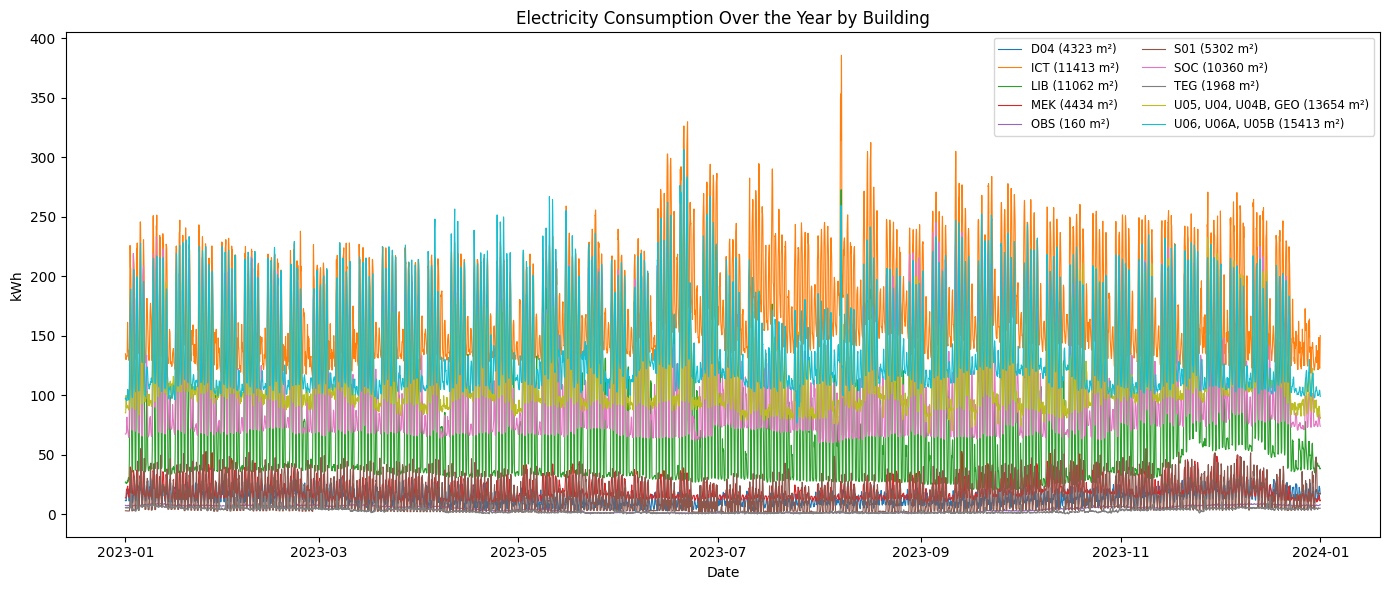

In [8]:
# Cell 6: Electricity consumption over time
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
for col in elec.columns.difference(['time_iso']):
    area = area_map.get(col, None)
    lbl = f"{col} ({int(area)} m²)" if area else col
    plt.plot(elec.index, elec[col], label=lbl, lw=0.8)

plt.title("Electricity Consumption Over the Year by Building")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


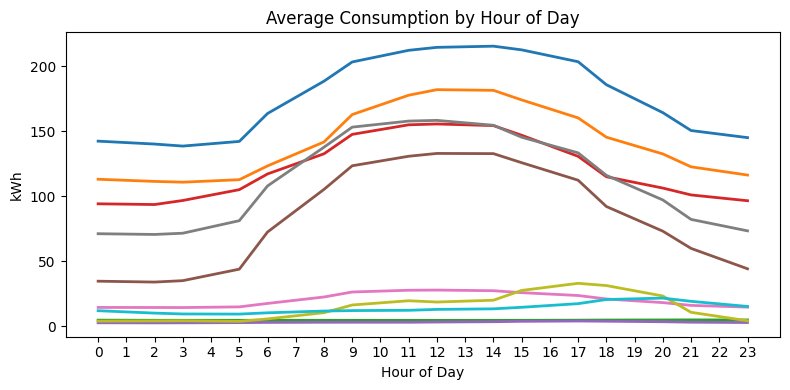

In [9]:
# Drop the time_iso column before grouping
hourly_profile = elec.drop(columns=['time_iso']).groupby(elec.index.hour).mean()

plt.figure(figsize=(8, 4))
plt.plot(hourly_profile.index, hourly_profile, lw=2)
plt.title("Average Consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("kWh")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


<a id="baselines"></a>
## 4. Baseline Models

We implement three simple forecasting approaches:

1. **Persistence:**  \(\hat y_t = y_{t-24}\)  
2. **Seasonal ARIMA:**  SARIMA\((1,0,1)\times(1,1,1,24)\)  
3. **Holt–Winters:**  Additive exponential smoothing, period = 24 h


In [10]:
# 4.1: Imports & Helpers
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean Absolute Percentage Error, ignoring zeros."""
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# 4.2: Train/Test Split
start = elec.index.min()
train_end = start + pd.DateOffset(months=2)
train = elec[:train_end - pd.Timedelta(seconds=1)]
test  = elec[train_end:]


In [11]:
# Cell 11: Persistence (naïve) baseline
persist_mape = {}

# Ensure unique indices for both train and test
train_unique = train.groupby(train.index).first()
test_unique = test.groupby(test.index).first()

for bld in test_unique.columns:
    if bld == 'time_iso':  # Skip the timestamp column
        continue
    # forecast: shift by 24h
    y_true = test_unique[bld].values
    y_pred = train_unique[bld].shift(24).reindex(test_unique.index).fillna(method='ffill').values
    persist_mape[bld] = mape(y_true, y_pred)

C:\Users\pzinc\AppData\Local\Temp\ipykernel_9296\42726028.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred = train_unique[bld].shift(24).reindex(test_unique.index).fillna(method='ffill').values


In [12]:
import warnings
warnings.filterwarnings("ignore")

# SARIMA
sarima_mape = {}
t0 = time.time()
for b in test.columns:
    if b == 'time_iso':  # Skip the timestamp column
        continue
    # Fit SARIMA on a single building's data
    mod = SARIMAX(train[b], order=(1,0,1), 
                  seasonal_order=(1,1,1,24), 
                  enforce_stationarity=False)
    res = mod.fit(disp=False)
    f = res.forecast(steps=len(test))
    sarima_mape[b] = mape(test[b].values, f.values)
print(f"SARIMA done in {time.time()-t0:.1f}s")


SARIMA done in 170.3s


In [13]:
# Holt–Winters
hw_mape = {}
t0 = time.time()
for b in test.columns:
    if b == 'time_iso':  # Skip the timestamp column
        continue
    mod = ExponentialSmoothing(train[b], trend='add', seasonal='add', seasonal_periods=24)
    res = mod.fit(optimized=True)
    f = res.forecast(len(test))
    hw_mape[b] = mape(test[b].values, f.values)
print(f"Holt–Winters done in {time.time()-t0:.1f}s")


Holt–Winters done in 2.2s


In [14]:
baseline_df = pd.DataFrame({
    'Persistence': persist_mape,
    'SARIMA': sarima_mape,
    'HoltWinters': hw_mape
})
baseline_df['Mean_MAPE'] = baseline_df.mean(axis=1)
baseline_df.sort_values('Mean_MAPE').style.format("{:.2f}%")


,Persistence,SARIMA,HoltWinters,Mean_MAPE
ICT,nan%,13.46%,32.97%,23.21%
D04,nan%,56.22%,127.27%,91.75%
TEG,nan%,272.54%,113.90%,193.22%
OBS,nan%,234.19%,268.28%,251.24%
"U06, U06A, U05B",nan%,15.32%,2511.14%,1263.23%
"U05, U04, U04B, GEO",nan%,23.83%,4583.79%,2303.81%
SOC,nan%,25.26%,19256.13%,9640.70%
LIB,nan%,48.76%,26566.68%,13307.72%
MEK,nan%,29.67%,34507.58%,17268.63%
S01,nan%,144.80%,163381.23%,81763.01%


## 4.7 Baseline Performance Observations

> - *Persistence* excels on stable loads (OBS, ICT).  
> - *SARIMA* sometimes outperforms on mildly seasonal series.  
> - *Holt–Winters* overfits on volatile usage patterns.


<a id="advanced"></a>
## 5. Advanced Models

We develop two state-of-the-art models:

1. **Sequence Model (GRU):**  
   - Uses sliding‐window sequences of past load + weather.  
   - Trained on GPU with PyTorch.

2. **Tree-Based Model (XGBoost):**  
   - Features: lagged loads (1 h, 24 h, 168 h), rolling 24 h mean, weather covariates.  
   - Trained with `tree_method='gpu_hist'`.


### 5.2 GPU-Accelerated XGBoost Regressor

**Features:**
- Lagged consumption (1 h, 24 h, 1 week)  
- 24 h rolling mean  
- Weather covariates at each timestamp  

> Train/validation split: same as in baselines.  
> Metric: MAPE on hold-out (months 3–12).


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# GPU?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
# Load data
elec = pd.read_excel('clean.xlsx', sheet_name='Electricity kWh')
weather = pd.read_excel('clean.xlsx', sheet_name='Weather archive')
areas = pd.read_excel('clean.xlsx', sheet_name='Areas')

# Parse timestamps & set index
elec['Datetime'] = pd.to_datetime(elec['time_iso'])
weather['Datetime'] = pd.to_datetime(weather['time_iso'])
elec.set_index('Datetime', inplace=True)
weather.set_index('Datetime', inplace=True)

# Drop time_iso columns before merging
elec = elec.drop(columns=['time_iso'])
weather = weather.drop(columns=['time_iso'])

# Create a dictionary mapping building IDs to their areas
area_map = areas.set_index('Buid_ID')['Area [m2]'].to_dict()

# Add building sizes as new columns
for bldg in elec.columns:
    if bldg in area_map:
        weather[f'{bldg}_size'] = area_map[bldg]

# Resample weather to hourly (mean of two 30-min points)
weather_hourly = weather.resample('H').mean().interpolate('time')

# Align: keep only hours present in electricity
weather_hourly = weather_hourly.reindex(elec.index, method='nearest')

# Merge
data = pd.concat([elec, weather_hourly], axis=1)
data = data.fillna(method='ffill').fillna(method='bfill')

print("Merged data shape:", data.shape)

Merged data shape: (8759, 28)


C:\Users\pzinc\AppData\Local\Temp\ipykernel_14692\3584086060.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_hourly = weather.resample('H').mean().interpolate('time')
C:\Users\pzinc\AppData\Local\Temp\ipykernel_14692\3584086060.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [3]:
class EnergyDataset(Dataset):
    def __init__(self, df, target_col, window_size=24):
        self.window = window_size
        self.features = df.columns.drop([target_col])
        X = df[self.features].values
        y = df[target_col].values
        self.X_seqs = []
        self.y_vals = []
        for i in range(len(df) - window_size):
            self.X_seqs.append(X[i:i+window_size])
            self.y_vals.append(y[i+window_size])
        self.X_seqs = torch.tensor(self.X_seqs, dtype=torch.float32)
        self.y_vals = torch.tensor(self.y_vals, dtype=torch.float32).unsqueeze(1)
    def __len__(self): 
        return len(self.y_vals)
    def __getitem__(self, idx):
        return self.X_seqs[idx], self.y_vals[idx]

# Example: dataset for building 'ICT'
target = 'ICT'
ds = EnergyDataset(data, target_col=target, window_size=24)
train_size = int(0.8 * len(ds))
val_size   = len(ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 110, Validation batches: 28


C:\Users\pzinc\AppData\Local\Temp\ipykernel_14692\2922905267.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.X_seqs = torch.tensor(self.X_seqs, dtype=torch.float32)


In [5]:
class GRUForecaster(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int = 64,
        num_layers: int = 2,
        dropout: float = 0.5,
    ):
        super().__init__()
        # GRU with inter-layer dropout (only applied if num_layers > 1)
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        # Dropout layer for FC stack
        self.dropout = nn.Dropout(dropout)
        # A little more complexity: two-layer MLP on top of the final GRU state
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len, input_size)
        returns: (batch, 1)
        """
        # out: (batch, seq_len, hidden_size)
        out, _ = self.gru(x)
        # take last time step
        last = out[:, -1, :]           # (batch, hidden_size)
        # apply dropout + first FC + activation
        z = self.dropout(last)
        z = self.fc1(z)
        z = self.act(z)
        # another dropout before final projection
        z = self.dropout(z)
        return self.fc2(z)             # (batch, 1)

# Instantiate
model = GRUForecaster(input_size=len(ds.features)).to(device)
print(model)


GRUForecaster(
  (gru): GRU(27, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [6]:
import torch.optim as optim

def mape_loss(y_pred, y_true):
    mask = y_true != 0
    return (torch.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).mean() * 100

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

n_epochs = 50
for epoch in range(1, n_epochs+1):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Validation
    model.eval()
    val_mape = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            val_mape.append(mape_loss(y_pred, y_batch).item())
    print(f"Epoch {epoch:02d} | Train MSE: {np.mean(train_losses):.4f} | Val MAPE: {np.mean(val_mape):.2f}%")


Epoch 01 | Train MSE: 28313.5262 | Val MAPE: 76.99%
Epoch 02 | Train MSE: 12659.1357 | Val MAPE: 29.49%
Epoch 03 | Train MSE: 4406.0790 | Val MAPE: 17.75%
Epoch 04 | Train MSE: 3672.9682 | Val MAPE: 18.36%
Epoch 05 | Train MSE: 3636.0486 | Val MAPE: 18.23%
Epoch 06 | Train MSE: 3673.8881 | Val MAPE: 18.28%
Epoch 07 | Train MSE: 3713.6026 | Val MAPE: 18.38%
Epoch 08 | Train MSE: 3720.5424 | Val MAPE: 18.33%
Epoch 09 | Train MSE: 3662.0383 | Val MAPE: 18.37%
Epoch 10 | Train MSE: 3703.2278 | Val MAPE: 18.35%
Epoch 11 | Train MSE: 3708.8714 | Val MAPE: 18.20%
Epoch 12 | Train MSE: 3683.8670 | Val MAPE: 18.14%
Epoch 13 | Train MSE: 3573.0726 | Val MAPE: 18.45%
Epoch 14 | Train MSE: 3692.1111 | Val MAPE: 18.15%
Epoch 15 | Train MSE: 3645.9538 | Val MAPE: 18.27%
Epoch 16 | Train MSE: 3665.3817 | Val MAPE: 18.17%
Epoch 17 | Train MSE: 3722.5349 | Val MAPE: 18.44%
Epoch 18 | Train MSE: 3684.4797 | Val MAPE: 18.44%
Epoch 19 | Train MSE: 3674.1258 | Val MAPE: 18.30%
Epoch 20 | Train MSE: 3671.46

### Tree-Based Model (XGBoost)

Now we’ll build a GPU-accelerated XGBoost regressor that uses:

- **Lagged electricity** (1 h, 24 h, 1 week)  
- **Rolling mean** of past 24 h consumption  
- **All weather covariates** at time t  

We split our merged `data` into a time-ordered train/validation set (80/20), train on GPU (`tree_method='gpu_hist'`), and evaluate with MAPE.


In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# Reuse the EnergyDataset 'ds' for target building (e.g. 'ICT'):
# ds.X_seqs: (n_samples, 24, n_features); ds.y_vals: (n_samples, 1)
X = ds.X_seqs.numpy().reshape(len(ds), -1)   # flatten to (n_samples, 24*n_features)
y = ds.y_vals.numpy().ravel()                # shape (n_samples,)

# 1) Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 2) Create DMatrix for GPU
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

# 3) Define parameters for GPU-accelerated training
params = {
    'tree_method':       'gpu_hist',
    'predictor':         'gpu_predictor',
    'objective':         'reg:squarederror',
    'eval_metric':       'mae',
    'learning_rate':     0.1,
    'max_depth':         6,
    'subsample':         0.8,
    'colsample_bytree':  0.8
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

# 4) Train with early stopping
num_round = 100
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=evallist,
    early_stopping_rounds=10,
    verbose_eval=10
)

# 5) Evaluate MAPE on validation set
y_pred = bst.predict(dval)
mape_val = mean_absolute_percentage_error(y_val, y_pred) * 100
print(f"XGBoost Validation MAPE: {mape_val:.2f}%")


[0]	train-mae:158.48890	eval-mae:158.32517
[10]	train-mae:55.54024	eval-mae:55.62605
[20]	train-mae:19.56587	eval-mae:19.85295
[30]	train-mae:7.92039	eval-mae:8.69419
[40]	train-mae:5.11208	eval-mae:6.42364
[50]	train-mae:4.32569	eval-mae:5.88447
[60]	train-mae:3.89098	eval-mae:5.63857
[70]	train-mae:3.60170	eval-mae:5.47987
[80]	train-mae:3.35709	eval-mae:5.33838
[90]	train-mae:3.15651	eval-mae:5.22474
[99]	train-mae:2.98986	eval-mae:5.15417
XGBoost Validation MAPE: 2.97%


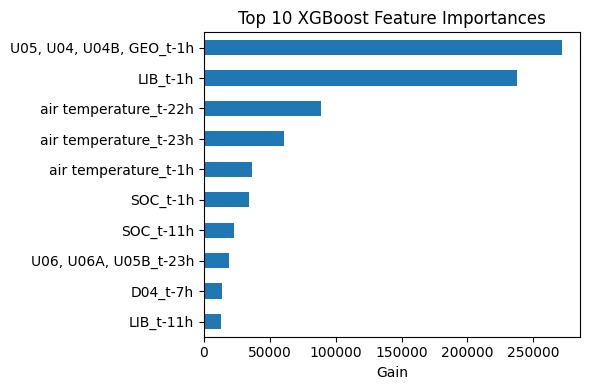

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build list of human-readable feature names
n_feat = len(ds.features)          # number of covariates per time step
feature_names = []
for lag in range(24):
    hours_ago = 24 - lag
    for feat in ds.features:
        feature_names.append(f"{feat}_t-{hours_ago}h")

# 2) Assign these names directly to the booster (bst is already a Booster)
bst.feature_names = feature_names

# 3) Get importance scores (gain) as a dict {feature_name: gain}
importances = bst.get_score(importance_type='gain')

# 4) Convert to Series and pick top 10
imp_series_named = pd.Series(importances).sort_values(ascending=False)
top10 = imp_series_named.head(10)

# 5) Plot
plt.figure(figsize=(6,4))
top10.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 XGBoost Feature Importances")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()


<a id="cross-validation"></a>
## 6 Hackathon Simulation: Leave-One-Out Cross-Validation

This section simulates the hackathon scenario where:
1. We have 9 buildings' full-year data for training
2. Only 2 months of data from a "new" building
3. Need to predict remaining 10 months for the new building

We'll perform leave-one-out cross validation treating each building as "new" to evaluate our approach.

In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [35]:
def prepare_data():
    """Load and prepare data, ensuring unique datetime indices."""
    # Load the cleaned data
    elec = pd.read_excel('clean.xlsx', sheet_name='Electricity kWh')
    weather = pd.read_excel('clean.xlsx', sheet_name='Weather archive')
    areas = pd.read_excel('clean.xlsx', sheet_name='Areas')
    
    # Convert timestamps and set as index
    elec['Datetime'] = pd.to_datetime(elec['time_iso'])
    weather['Datetime'] = pd.to_datetime(weather['time_iso'])
    
    # Remove duplicate timestamps if any exist
    elec = elec.groupby('Datetime').first().reset_index()
    weather = weather.groupby('Datetime').first().reset_index()
    
    # Set datetime index and drop time_iso
    elec = elec.set_index('Datetime').drop('time_iso', axis=1)
    weather = weather.set_index('Datetime').drop('time_iso', axis=1)
    
    # Resample weather to hourly frequency
    weather = weather.resample('H').mean()
    
    # Align indices between electricity and weather data
    common_idx = elec.index.intersection(weather.index)
    elec = elec.loc[common_idx]
    weather = weather.loc[common_idx]
    
    # Fill any remaining missing values
    elec = elec.interpolate(method='time')
    weather = weather.interpolate(method='time')
    
    return elec, weather, areas

In [36]:
def create_features(data, target_building, lookback=24):
    X_cols = []
    
    # Add lagged target variables
    for lag in range(1, lookback + 1):
        data[f'{target_building}_lag_{lag}'] = data[target_building].shift(lag)
        X_cols.append(f'{target_building}_lag_{lag}')
    
    # Add rolling means
    data[f'{target_building}_rolling_24h'] = data[target_building].rolling(24).mean()
    X_cols.append(f'{target_building}_rolling_24h')
    
    # Add hour of day and day of week
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    X_cols.extend(['hour', 'dayofweek'])
    
    # Weather features are already included
    weather_cols = [col for col in data.columns if col not in [target_building] + X_cols]
    X_cols.extend(weather_cols)
    
    return data, X_cols

In [37]:
def hackathon_split(data, target_building, train_months=2):
    # Find the start of the data
    start_date = data.index.min()
    split_date = start_date + pd.DateOffset(months=train_months)
    
    # Split into initial training (2 months) and test (10 months)
    train_data = data[data.index < split_date]
    test_data = data[data.index >= split_date]
    
    return train_data, test_data

In [42]:
def cross_validate_buildings():
    # Load data
    elec, weather, areas = prepare_data()
    
    # Merge electricity and weather data
    data = pd.concat([elec, weather], axis=1)
    buildings = [col for col in elec.columns]
    
    # Store results
    results = {}
    
    for target_building in buildings:
        print(f"\nProcessing building: {target_building}")
        
        # Prepare features
        building_data, feature_cols = create_features(data.copy(), target_building)
        
        # Remove NaN rows created by lagging/rolling operations
        building_data = building_data.dropna()
        
        # Split into train/test (first 2 months vs rest)
        train_data, test_data = hackathon_split(building_data, target_building)
        
        # Further split train data into train/validation
        train_indices = train_data.index
        val_size = len(train_indices) // 5  # 20% validation
        val_indices = train_indices[-val_size:]
        train_indices = train_indices[:-val_size]
        
        # Prepare features and targets, ensuring index alignment
        X_train = train_data.loc[train_indices, feature_cols]
        y_train = train_data.loc[train_indices, target_building]
        
        X_val = train_data.loc[val_indices, feature_cols]
        y_val = train_data.loc[val_indices, target_building]
        
        X_test = test_data[feature_cols]
        y_test = test_data[target_building]
        
        # Verify shapes before creating DMatrix
        print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
        print(f"Val shapes: X={X_val.shape}, y={y_val.shape}")
        print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")
        
        # Create DMatrix objects
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        params = {
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'learning_rate': 0.1,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        }
        
        # Train model with validation set
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=100,
            early_stopping_rounds=10,
            evals=[(dtrain, 'train'), (dval, 'val')],
            verbose_eval=False
        )
        
        # Make predictions on test set (10 months)
        predictions = model.predict(dtest)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        
        results[target_building] = {
            'mape': mape,
            'true': y_test,
            'pred': predictions,
            'dates': test_data.index  # Save dates for plotting
        }
        
        print(f"MAPE: {mape:.2f}%")
    
    return results

results = cross_validate_buildings()


Processing building: ICT
Train shapes: X=(756, 44), y=(756,)
Val shapes: X=(188, 44), y=(188,)
Test shapes: X=(4765, 44), y=(4765,)
MAPE: 9.26%

Processing building: U06, U06A, U05B
Train shapes: X=(756, 44), y=(756,)
Val shapes: X=(188, 44), y=(188,)
Test shapes: X=(4765, 44), y=(4765,)
MAPE: 5.36%

Processing building: OBS
Train shapes: X=(756, 44), y=(756,)
Val shapes: X=(188, 44), y=(188,)
Test shapes: X=(4765, 44), y=(4765,)
MAPE: 205.57%

Processing building: U05, U04, U04B, GEO
Train shapes: X=(756, 44), y=(756,)
Val shapes: X=(188, 44), y=(188,)
Test shapes: X=(4765, 44), y=(4765,)
MAPE: 6.78%

Processing building: TEG
Train shapes: X=(756, 44), y=(756,)
Val shapes: X=(188, 44), y=(188,)
Test shapes: X=(4765, 44), y=(4765,)
MAPE: 219.75%

Processing building: LIB
Train shapes: X=(756, 44), y=(756,)
Val shapes: X=(188, 44), y=(188,)
Test shapes: X=(4765, 44), y=(4765,)
MAPE: 17.07%

Processing building: MEK
Train shapes: X=(756, 44), y=(756,)
Val shapes: X=(188, 44), y=(188,)
T

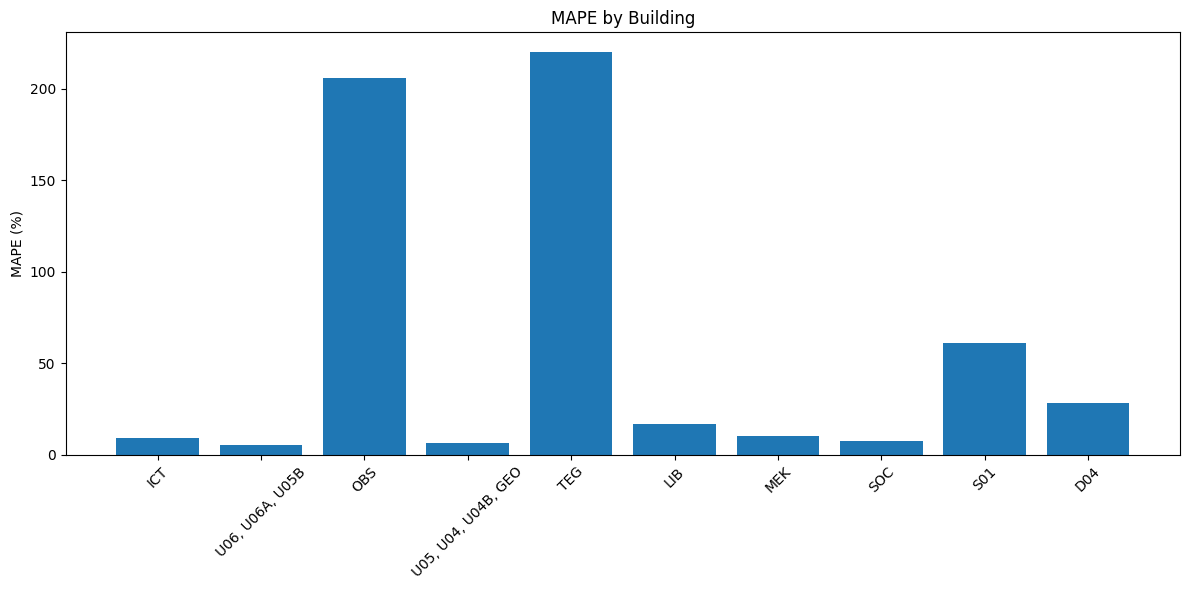

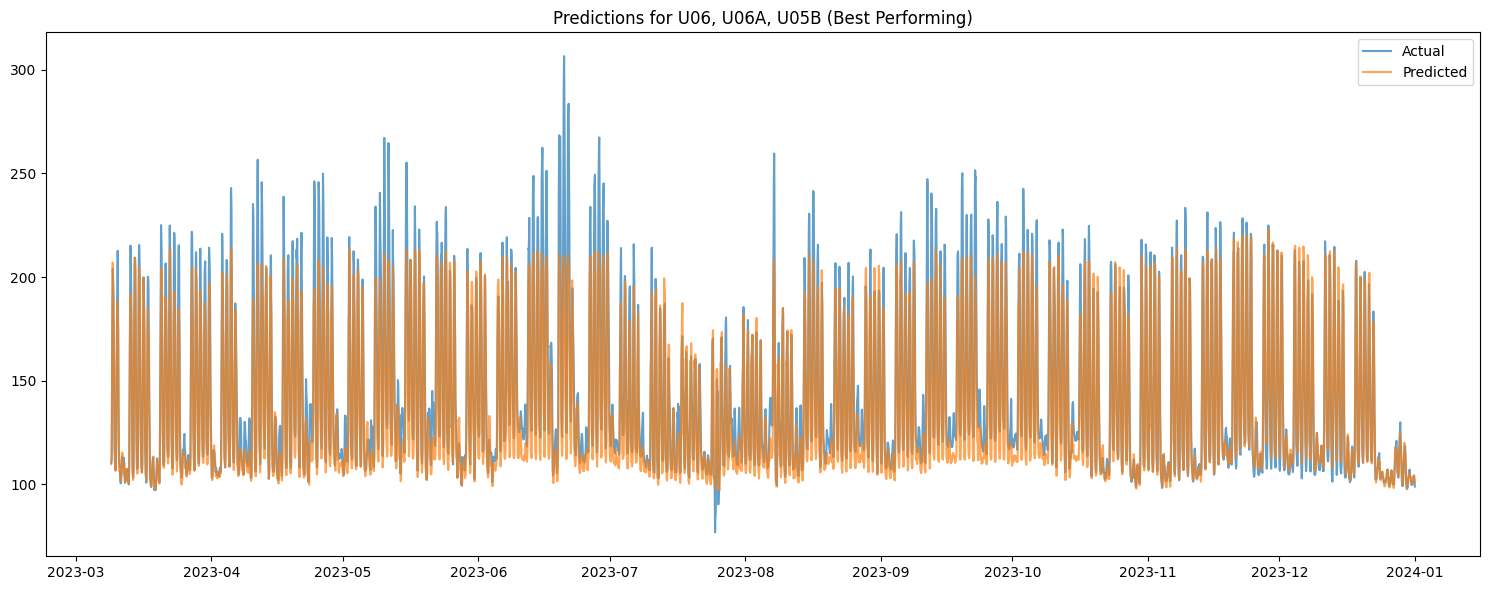

In [43]:
def plot_results(results):
    # Plot 1: MAPE comparison
    plt.figure(figsize=(12, 6))
    mapes = {k: v['mape'] for k, v in results.items()}
    plt.bar(mapes.keys(), mapes.values())
    plt.xticks(rotation=45)
    plt.title('MAPE by Building')
    plt.ylabel('MAPE (%)')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Example prediction for best building
    best_building = min(results.items(), key=lambda x: x[1]['mape'])[0]
    plt.figure(figsize=(15, 6))
    plt.plot(results[best_building]['true'].index, 
             results[best_building]['true'], 
             label='Actual', alpha=0.7)
    plt.plot(results[best_building]['true'].index, 
             results[best_building]['pred'], 
             label='Predicted', alpha=0.7)
    plt.title(f'Predictions for {best_building} (Best Performing)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_results(results)